In [1]:
import torch
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from model import Encoder



import matplotlib.pyplot as plt

from tqdm import tqdm



In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:

VAL_RATIO = 0.2

#The ratio of the total training set used only for validation

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(3), # adds 6 to both the height and width to make it 256,256
    transforms.Resize(64)
])



dataset = torchvision.datasets.LFWPairs(root = "PyTorch\\",download="True",split="train", transform=transform)

INPUT_SHAPE = (3,250,250)
VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])

print(val_len,train_len)

image1, image2, label =  train_dataset[0]
image1, image2 = image1.to(torch.device("cuda")), image2.to(torch.device("cuda"))
img_size = image1.shape
image1.shape, image2.shape, label, image1.min(), image1.max()

Files already downloaded and verified
440 1760


(torch.Size([3, 64, 64]),
 torch.Size([3, 64, 64]),
 1,
 tensor(0., device='cuda:0'),
 tensor(0.9980, device='cuda:0'))

In [5]:

len(train_dataset), len(train_dataset), len(val_dataset), len(val_dataset)

(1760, 1760, 440, 440)

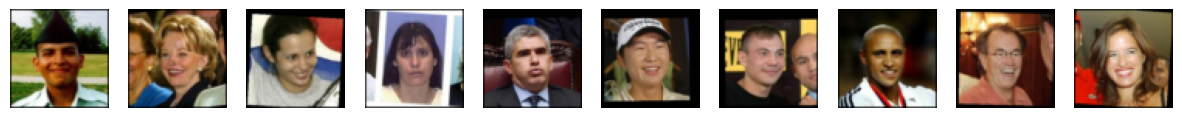

In [6]:
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
idxs = torch.randperm(len(train_dataset))[:10] #10 random images
for i, ax in enumerate(axes):
    img, img2, label = train_dataset[idxs[i]]
    ax.imshow(img.cpu().permute(1,2,0)) #moves dimensions 3,250,250 --> 250,250,3
    ax.axis('off')
plt.show()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

In [8]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Encoder(32, img_size)
model = model.to(device)
testx = torch.randn(img_size).unsqueeze(0).to(device)
testout = model(testx)
print(testout.shape)
optimiser = torch.optim.AdamW(model.parameters(), lr=3e-4)
lossarray = []


torch.Size([1, 128])


In [12]:
def validate(model, validation_set, threshold=0.8):
    model.eval()
    neg_loss = 0
    pos_loss = 0
    num_pos = 0 
    num_neg = 0
    valdataloader = DataLoader(val_dataset, 64, shuffle=False)
    for (image1, image2, label) in valdataloader:
        images1 = image1.to(device)
        images2 = image2.to(device)
        labels = label.to(device)
        out1 = model(images1)
        out2 = model(images2)
        labels = (labels - 0.5)*2 
        loss = F.mse_loss(out1, out2, reduction="none").mean(1)
        neg_loss += loss[labels==-1].sum()
        pos_loss += loss[labels==1].sum()
        num_neg += (labels==-1).sum()
        num_pos += (labels==1).sum()
    neg_loss = neg_loss/num_neg
    pos_loss = pos_loss/num_pos
    return neg_loss, pos_loss

In [13]:
batchsize = 16
num_epochs = 10
traindataloader = DataLoader(train_dataset, batchsize, shuffle=True)
neg_loss_array = []
pos_loss_array = []
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(traindataloader, leave=True, total = len(traindataloader))
   
    if epoch > 0:
        loop.set_description(f"Epoch : {epoch}/{num_epochs}")
        loop.set_postfix({"Loss" : lossarray[-1], "Negative MSE " : neg_loss_array[-1], "Positive MSE ": pos_loss_array[-1], "Diff MSE" : neg_loss_array[-1]-pos_loss_array[-1]})
        
    
    batchlosses = []
    i=0

    for (images1, images2, labels) in loop:
        images1 = images1.to(device)
        images2 = images2.to(device)
        labels = labels.to(device)
        out1 = model(images1)
        out2 = model(images2)

        labels = (labels - 0.5)*2 
        loss = F.mse_loss(out1, out2, reduction="none").mean(1)
        loss = loss*labels # mean squared error calculates the distance between the 2 images and then squares it to take the absolute distance between them. This will produce a vector with the distance between each weight in the node
        #print(loss)
        loss = loss.mean()
        #print(loss)
        loss.backward() # backward needs to be done on a vector object and mean reduces the dimensions of the loss.
        batchlosses.append(loss.item()) #gives the value rather than the object

    lossarray.append(sum(batchlosses)/len(batchlosses))
    with torch.no_grad(): #dont create a computation graph as backpropagation not necessary
        neg_loss, pos_loss = validate(model, val_dataset)
    neg_loss_array.append(neg_loss.item())
    pos_loss_array.append(pos_loss.item())





Epoch : 9/10: 100%|██████████| 110/110 [00:19<00:00,  5.72it/s, Loss=-0.00288, Negative MSE =0.00432, Positive MSE =0.00419, Diff MSE=0.000128]


In [11]:
#write comparison script between faces
#function that takes 2 faces as input and returns same or not.
# vector output -- 128 in length, vector difference and determine threshold
#saves state dict
